# Notebook 3: Analyzing ERA5 Model Reanalysis Data Using Xarray and CartoPy

### By Tyson Stewart

(Note: This notebook is inspired upon my thesis work, which is using ERA5 data in conjunction with WRF-ARW to assess how lake-effect snow is changed in a warming climate. Since ERA5 is critical to that research, I wanted to use this opportunity to explore visualizing it and similar datasets in Python)

#### Introduction
A common use of Python in the atmospheric sciences is to display and analyze meteorlogical data. While much of the work in this class as well as in EAE 493 has been focusing on basic, non-spatial data, we can use Python to great effect in displaying spatial data as well. To illustrate this, we will be using Cartopy and Xarray (as well as matplotlib) to visualize ERA5 reanalysis data. This process is based lightly upon [a tutorial notebook created by Joseph Finlon of the University of Washington](https://atmos.uw.edu/~jfinlon/impacts/ERA5_analysis.html) as well as heavily based upon the [example notebook provided on the xarray documentation website.](https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html) While this notebook is focused on ERA5, and specifically the ERA5 data provided by Xarray, much of this process will be applicable to other spatial data datasets.

#### Step 1: Importing Data and Packages

To start, let's begin by importing both the necessary packages, as well as downloading our ERA5 data courtesy of the built in xarray tutorial dataset.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy

In [2]:
dataset = xr.tutorial.open_dataset("era5-2mt-2019-03-uk.grib", engine = "cfgrib")

In [3]:
dataset

<xarray.Dataset>
Dimensions:     (time: 744, latitude: 33, longitude: 49)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-03-01 ... 2019-03-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 58.0 57.75 57.5 57.25 ... 50.5 50.25 50.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 1.25 1.5 1.75 2.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    t2m         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-06T03:15 GRIB to CDM+CF via cfgrib-0.9.1...

Looking at the xarray dataset, there are 5 major sections to observe.

First is our dimensions view, which shows how big our file is along each of the indexes. In this case, our dataset consists of a grid 33x49 units big with 744 "slides" of data. Next is the coordinates sections, which highlights our time, latitude, and longitude indexes mentioned earlier. After coordinates comes our data variables, which for this tutorial dataset only consists of 2 meter temperature data ("t2m"). After this and the indexes section (which once again just shows latitude, longitude, and time) is the attributes section which shows some dataset metadata.

Before we begin visualizing the data, it may be helpful to first look at where this data is for. To do this we can take advantage of cartopy and the latitude and longitude data we saw earlier.

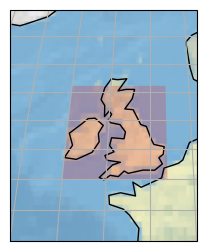

In [4]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
ax.coastlines(resolution='110m')
ax.gridlines()

ax.add_patch(mpatches.Rectangle(xy=[-10, 50], width=12, height=8, facecolor='red', alpha=0.2, transform=ccrs.PlateCarree()))
ax.set_extent([-15, 5, 45, 65], crs=ccrs.PlateCarree())

plt.show()

As we can see in the map above, our data is of the United Kingdom and Ireland. This is a fairly small area, but it should mean that the time to process the data is quicker compared to say, analyzing data of the whole United States.

#### Step 2: Displaying ERA5 Data

With our ERA5 data loaded onton a dataframe (which we gave the variable name"dataset"), we can begin to display it using cartopy. There is a way to visualize the data directly from xarray however the end result lacks some of the additional shapefiles necessary to contextualize the information. This rough visualization can be seen below (Note that the default unit is in Kelvin so we have to apply an operation to convert it into Celsius):

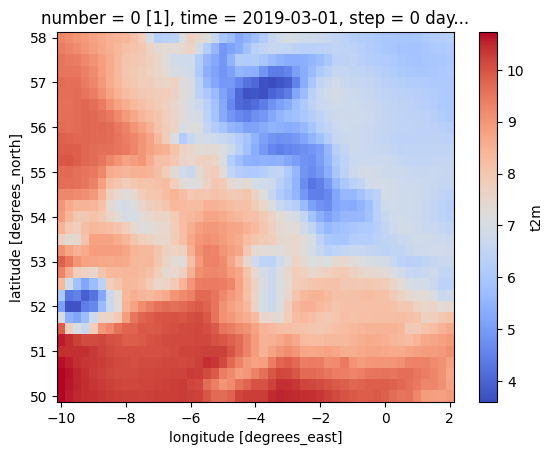

In [5]:
#Convert from Kelvin to C
dataset_C = dataset - 273.15

dataset_C.t2m[0].plot(cmap=plt.cm.coolwarm)

By comparison, this is the same data plotted using Cartopy and the included shapefiles:

Text(0.5, 1.0, 'ERA5 - 2m temperature British Isles March 2019')

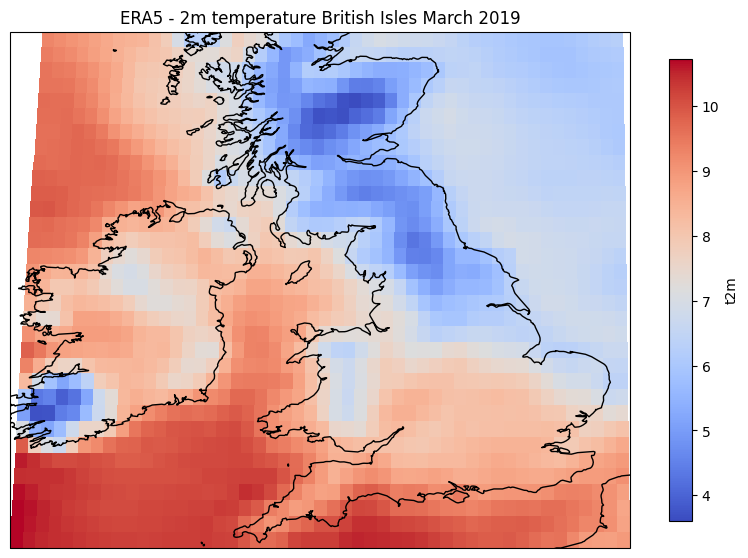

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
plot = dataset_C.t2m[0].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6})
plt.title("ERA5 - 2m temperature British Isles March 2019")

Notice how with a simple addition of the geographic borders the same data becomes much more clear? Suddenly the odd blueish shapes from the first visualization can be now be understood to be colder temperatures around Scotland and Northern England. We also can now identify the anomalous blue dot in the southwest to be positioned over SW Ireland.

#### Step 3: Analyzing Data at Grid Points
Say we wanted to explore the temperature data around this region more, how would we do that? One option could be to create a loop from all of the different time intervals, however this may require additional packages and with it more work. Another option is to create a line graph of the temperature data from that point. Thankfully this can be done via xarray and matplotlib with the following code:

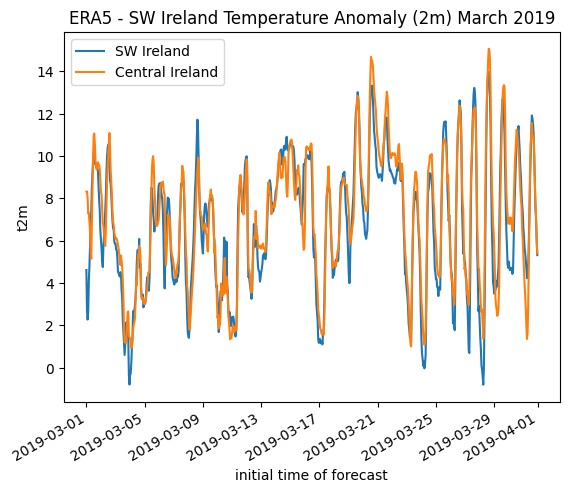

In [7]:
#Select all of the data from the anomaly region and plot it
dataset_C.t2m.sel(longitude=-9, latitude=52).plot(label = "SW Ireland")
dataset_C.t2m.sel(longitude=-7.5, latitude=53).plot(label = "Central Ireland")

#Add a title to it
plt.title("ERA5 - SW Ireland Temperature Anomaly (2m) March 2019")
plt.legend()

Looking at the data over the entire period, we can observe that both regions seem to usually coorespond with eachother, but at this scale it's hard to see whats going on for our particular time period. Thankfully we can isolate the first period of observations using indexing.

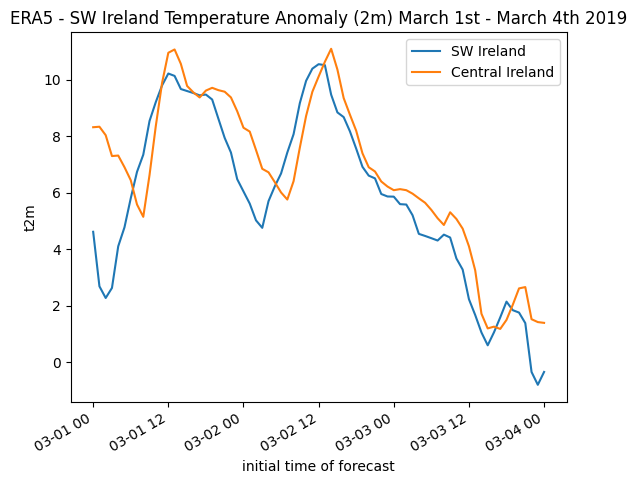

In [8]:
#Select all of the data from the anomaly region and plot it (Note that we are now using indexing as seen with the "[0:72]")
dataset_C.t2m.sel(longitude=-9, latitude=52)[0:73].plot(label = "SW Ireland")
dataset_C.t2m.sel(longitude=-7.5, latitude=53)[0:73].plot(label = "Central Ireland")

#Add a title to it
plt.title("ERA5 - SW Ireland Temperature Anomaly (2m) March 1st - March 4th 2019")
plt.legend()

Suddenly now we can observe that there is a considerable lag in the temperature observation patterns between Southwest ireland and Central Ireland throughout March 1st and March 2nd before both sets of observations converge heading into the 3rd. This suggests that something happened on those first two days to induce that sort of temperature pattern change.

As can hopefully be seen by this example analysis, Python is a powerful tool in an atmospheric scientist's arsenal to analyze spatial data. Using xarray, cartopy, and matplotlib we were able to analyze the temperature of a given region, identify anomalies, and investigate them. All the while generating vizualizations and graphics of the data.